# US Accident Exploratory Data Analysis

In [3]:
!pip install opendatasets --upgrade --quiet
!pip install geopandas --quiet
!pip install squarify --quiet

     |████████████████████████████████| 1.0 MB 7.4 MB/s 
     |████████████████████████████████| 6.3 MB 35.9 MB/s 
     |████████████████████████████████| 15.4 MB 45.2 MB/s 


In [4]:
import opendatasets
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import geopandas as gpd
from shapely.geometry import Point
import squarify

## Data Preparation and Cleaning

#### Download Data

In [5]:
#adding data source url from kaggle
source_url= "https://www.kaggle.com/sobhanmoosavi/us-accidents"

#downloading dataset. user_id and API key is available at 'yourKaggleProfile'>AccountSetting>API>CreateNewAPItoken
opendatasets.download(source_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shitabtanzim
Your Kaggle Key: ··········


100%|██████████| 117M/117M [00:00<00:00, 188MB/s]


In [6]:
#adding file path
filename= "./us-accidents/US_Accidents_Dec20_updated.csv" 

In [7]:
#importing data file as a pandas dataframe
df= pd.read_csv(filename)

#### Basic informations about the data

In [8]:
df.head(3)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2716600,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.10891,-83.09286,40.11206,-83.03187,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2716601,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.86542,-84.06280,39.86501,-84.04873,0.747,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-2716602,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10266,-84.52468,39.10209,-84.52396,0.055,At I-71/US-50/Exit 1 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45203,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day


In [9]:
print(f'Number of rows: {df.shape[0]}\nNumber of columns: {df.shape[1]}')

Number of rows: 1516064
Number of columns: 47


In [10]:
df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [11]:
#printing each column name, it's first value, and it's datatype
for c in df.columns:
  print(c, df[c][0], type(df[c][0]), sep="\t")

ID	A-2716600	<class 'str'>
Severity	3	<class 'numpy.int64'>
Start_Time	2016-02-08 00:37:08	<class 'str'>
End_Time	2016-02-08 06:37:08	<class 'str'>
Start_Lat	40.10891	<class 'numpy.float64'>
Start_Lng	-83.09286	<class 'numpy.float64'>
End_Lat	40.11206	<class 'numpy.float64'>
End_Lng	-83.03187	<class 'numpy.float64'>
Distance(mi)	3.23	<class 'numpy.float64'>
Description	Between Sawmill Rd/Exit 20 and OH-315/Olentangy Riv Rd/Exit 22 - Accident.	<class 'str'>
Number	nan	<class 'numpy.float64'>
Street	Outerbelt E	<class 'str'>
Side	R	<class 'str'>
City	Dublin	<class 'str'>
County	Franklin	<class 'str'>
State	OH	<class 'str'>
Zipcode	43017	<class 'str'>
Country	US	<class 'str'>
Timezone	US/Eastern	<class 'str'>
Airport_Code	KOSU	<class 'str'>
Weather_Timestamp	2016-02-08 00:53:00	<class 'str'>
Temperature(F)	42.1	<class 'numpy.float64'>
Wind_Chill(F)	36.1	<class 'numpy.float64'>
Humidity(%)	58.0	<class 'numpy.float64'>
Pressure(in)	29.76	<class 'numpy.float64'>
Visibility(mi)	10.0	<class 'n

In [12]:
# basics statistical detail of the numerical columns
df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,1.516064e+06,1.516064e+06,1.516064e+06,1.516064e+06,1.516064e+06,1.516064e+06,4.699690e+05,1.473031e+06,1.066748e+06,1.470555e+06,1.479790e+06,1.471853e+06,1.387202e+06,1.005515e+06
mean,2.238630e+00,3.690056e+01,-9.859919e+01,3.690061e+01,-9.859901e+01,5.872617e-01,8.907533e+03,5.958460e+01,5.510976e+01,6.465960e+01,2.955495e+01,9.131755e+00,7.630812e+00,8.477855e-03
std,6.081481e-01,5.165653e+00,1.849602e+01,5.165629e+00,1.849590e+01,1.632659e+00,2.242190e+04,1.827316e+01,2.112735e+01,2.325986e+01,1.016756e+00,2.889112e+00,5.637364e+00,1.293168e-01
min,1.000000e+00,2.457022e+01,-1.244976e+02,2.457011e+01,-1.244978e+02,0.000000e+00,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.385422e+01,-1.182076e+02,3.385420e+01,-1.182077e+02,0.000000e+00,1.212000e+03,4.700000e+01,4.080000e+01,4.800000e+01,2.944000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.735113e+01,-9.438100e+01,3.735134e+01,-9.437987e+01,1.780000e-01,4.000000e+03,6.100000e+01,5.700000e+01,6.800000e+01,2.988000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.072593e+01,-8.087469e+01,4.072593e+01,-8.087449e+01,5.940000e-01,1.010000e+04,7.300000e+01,7.100000e+01,8.400000e+01,3.004000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900058e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,1.551860e+02,9.999997e+06,1.706000e+02,1.130000e+02,1.000000e+02,5.804000e+01,1.400000e+02,9.840000e+02,2.400000e+01


In [13]:
#columns with categorical values & no. of categories
for x in df.select_dtypes(include=["object"]).columns:
       print(x, len(df[x].unique()), sep='---')

ID---1516064
Start_Time---1037092
End_Time---1161415
Description---527655
Street---93048
Side---2
City---10658
County---1671
State---49
Zipcode---177197
Country---1
Timezone---5
Airport_Code---1986
Weather_Timestamp---331749
Wind_Direction---25
Weather_Condition---117
Sunrise_Sunset---3
Civil_Twilight---3
Nautical_Twilight---3
Astronomical_Twilight---3


#### Feature Engineering

Todos:
- Deal with missing values.
- Change the Start_Time and End_Time from string to datetime.
- There are 4 column to indicate day/night. Selecting only 1 out of them.
- Weather_Condition column has several distinct classification. Try to re-classify them at a higher level

> Dropping the columns with excessive missing values :-

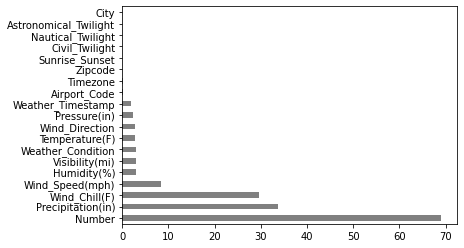

In [14]:
#calculating the percentage of missing values per column
missing_percentages= df.isna().sum().sort_values(ascending=False) / len(df) *100

#plotting columns with missing value
missing_percentages[missing_percentages!=0].plot(kind='barh', color='grey')
plt.show()

In [15]:
#Since the columns where more than 50% of the data is missing are not useful, we can delete them.
#dropping 'Number' column as a lot of data is missing
df= df.drop('Number', axis=1)

> Start_Time, End_Time and Weather_Timestamp is in str format and not datetime. So we have to typecast them.

In [16]:
#casting string datatype to datetime
df['Start_Time']= pd.to_datetime(df.Start_Time)
df['End_Time']= pd.to_datetime(df.End_Time)
df['Weather_Timestamp']= pd.to_datetime(df.Weather_Timestamp)

> Selecting 1 column to determine Day or Night

In [17]:
for x in ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']:
  print(df[x].value_counts())

Day      909838
Night    606143
Name: Sunrise_Sunset, dtype: int64
Day      969075
Night    546906
Name: Civil_Twilight, dtype: int64
Day      1035103
Night     480878
Name: Nautical_Twilight, dtype: int64
Day      1090946
Night     425035
Name: Astronomical_Twilight, dtype: int64


In [18]:
#Since we are dealing with road accidents, we will drop Civil, Nautical, and Astronomical Twilight.
#We will use Sunrise_Sunset to determine day or night.
df.drop(columns= ['Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis=1, inplace=True)

> Weather_Condition has very specific categories. We can re-classify it to a higher level.

In [19]:
print("Number of categories originally: ",len(df['Weather_Condition'].unique()))

Number of categories originally:  117


In [20]:
#function to standarize similar weather condition
def weather(original_text):
  text= str(original_text).lower()
  if 'rain' in text or 'drizzle' in text :
    return 'Rain'
  if 'cloud' in text or 'overcast' in text:
    return 'Cloudy' 
  if 'snow' in text:
    return 'Snow'
  if 'fog' in text or 'haze' in text:
    return 'Fog'
  if 'ice pellets' in text:
    return 'Ice Pellets'
  if 'thunder' in text or 'storm' in text:
    return 'Thunder-Storm'
  if 'dust' in text:
    return 'Dust'
  if 'windy' in text:
    return 'Windy'
  else:
    return original_text

df['Weather_Condition']= df['Weather_Condition'].apply(weather)

In [21]:
print("Number of categories now: ",len(df['Weather_Condition'].unique()))

Number of categories now:  24


## Exploratory Analysis and Data Visualisation

Todo:
Analyze
- Location -- City,  State
- Time -- Hour,  Week,  Month,  Year,  Day/Night
- Condition -- Road,  Weather
- Impact on traffic -- Severity,  Duration

### Location

#### City

In [22]:
total_cities= len(df.City.unique())
print(f"Number of cities: {total_cities}")

Number of cities: 10658


In [23]:
#creating a dataframe contain no. of accidents per city
df_city= pd.DataFrame(df['City'].value_counts())
df_city= df_city.reset_index().rename(columns={'index':'City', 'City':'Number_of_accidents'})
df_city.head(3)

,City,Number_of_accidents
0,Los Angeles,39984
1,Miami,36233
2,Charlotte,22203


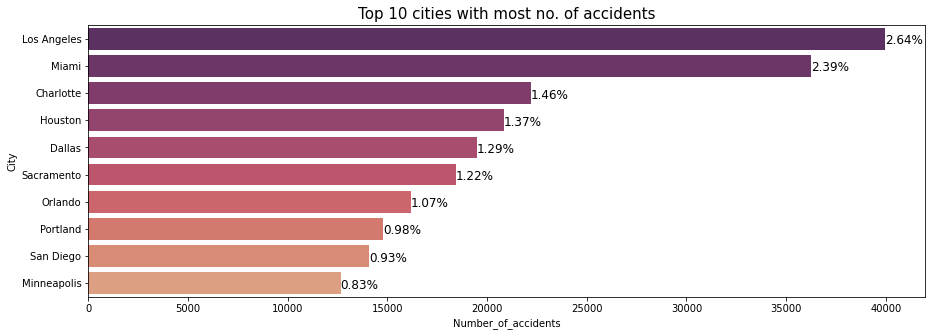

In [24]:
fig,ax = plt.subplots(figsize = (15,5))

#bar chart of the top 10 cities with most accidents
chart= sns.barplot(x="Number_of_accidents", y="City", data=df_city.head(10), palette="flare_r")

total_accident= sum(df_city.Number_of_accidents)

#show percentages
i=0
for c in chart.patches:
    width, height = c.get_width(), c.get_height()
    x, y = c.get_xy()
    plt.text(x+width,
             y+height*0.75,
             str(round(df_city.Number_of_accidents[i]/total_accident*100, 2))+"%",
             size=12)
    i+=1

#add title
plt.title("Top 10 cities with most no. of accidents", size=15)

plt.show()

In [25]:
print("Percentage of total accidents caused in top10 cities: ", end='')
print(round(sum(df_city.Number_of_accidents[:10])/total_accident*100))

Percentage of total accidents caused in top10 cities: 14


><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
>- **Los Angeles** is the city with most number of accidents **2.64**%; followed by **Miami** with **2.39**%
>- **14**% of the total accidents took place in these top **10** cities

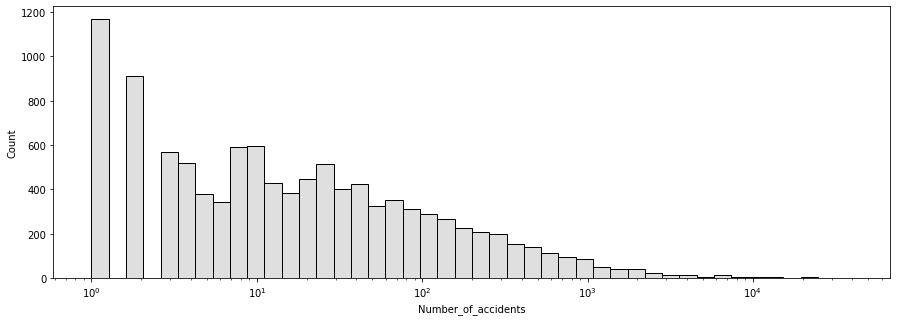

In [26]:
fig,ax = plt.subplots(figsize = (15,5))
plt.axes().set_facecolor("white")
sns.histplot(df_city.Number_of_accidents, log_scale=True,  color="grey", alpha=0.25)
plt.show()

In [27]:
for i in [1,10,100,1000,10000]:
  accidents= len(df_city.City[df_city.Number_of_accidents>i])
  perc= round(accidents/total_cities*100,2)
  print(f"{perc}% of the cities had more than {i} accidents")

89.04% of the cities had more than 1 accidents
54.18% of the cities had more than 10 accidents
18.36% of the cities had more than 100 accidents
2.36% of the cities had more than 1000 accidents
0.12% of the cities had more than 10000 accidents


><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
>- **11**% of the cities had only **1** accident.
>- Only **2.36**% of the cities had more than 1000 accidents.
>- No. of accidents per city changes logarithmically. Might depend on area and population of the city.

In [28]:
#dataframe containing coordinates of the US cities
#taking the average latitude and longitude of the accident in each city will give the coordinates.
df_city_coordinate= df[['Start_Lat','Start_Lng','City']].groupby('City').mean().reset_index()

#adding coordinates of the cities in df_city
df_city= df_city.merge(df_city_coordinate,on='City')

In [29]:
#creating a geopandas dataframe from geojason file containing USA's states boundary 
states = gpd.read_file('cb_2018_us_state_500k.shp')

#removing outlying states that isn't a part of USA mainland
states=states.drop(states[states['NAME']=='Commonwealth of the Northern Mariana Islands'].index, axis=0)
states=states.drop(states[states['NAME']=='Hawaii'].index, axis=0)
states=states.drop(states[states['NAME']=='United States Virgin Islands'].index, axis=0)
states=states.drop(states[states['NAME']=='Alaska'].index, axis=0)
states=states.drop(states[states['NAME']=='Puerto Rico'].index, axis=0)
states=states.drop(states[states['NAME']=='American Samoa'].index, axis=0)
states=states.drop(states[states['NAME']=='Guam'].index, axis=0)

In [30]:
#getting separate list of latitude and longitude of different
lng= list(df_city['Start_Lng'][:10])
lat= list(df_city['Start_Lat'][:10])

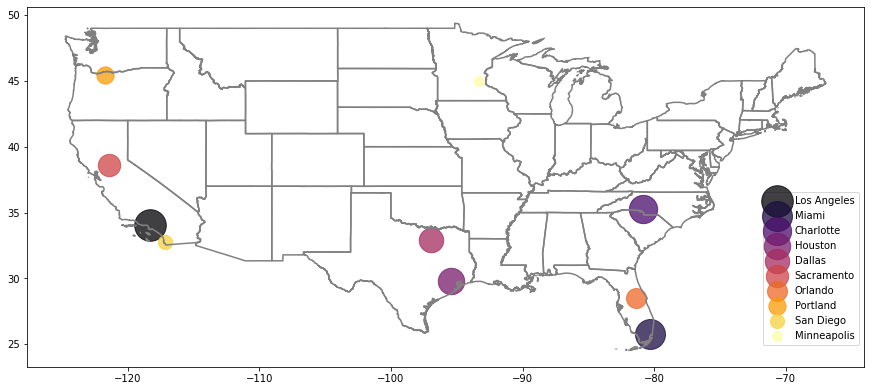

In [31]:
fig,ax = plt.subplots(figsize = (15,20))

#plotting base map
states.boundary.plot(ax=ax, color='grey')

#creating geopandas dataframe containing coordinates of top10 accident prone cities
geometry_cities = [Point(xy) for xy in zip(list(df_city['Start_Lng'][:10]), list(df_city['Start_Lat'][:10]))]
geo_df = gpd.GeoDataFrame(geometry = geometry_cities)


cmap = plt.get_cmap('inferno', 10)   
colors = [cmap(i) for i in range(cmap.N)]
markersizes= [100+(i*100) for i in range(10)][::-1]

#plotting cities on map
for i in range(10):
    geo_df[geo_df.index==i].plot(ax=ax, 
                                 markersize=markersizes[i], 
                                 marker='o', 
                                 color=colors[i],
                                 label=df_city['City'][i], 
                                 alpha=0.75);

plt.legend(bbox_to_anchor=(1,0.5))
plt.show()

><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
> - **3** out of **10** top accident prone cities are in the state of **California**

#### State

In [32]:
df['State'].unique()

array(['OH', 'IN', 'KY', 'WV', 'MI', 'PA', 'CA', 'NV', 'MN', 'TX', 'MO',
       'CO', 'OK', 'LA', 'KS', 'WI', 'IA', 'MS', 'NE', 'ND', 'WY', 'SD',
       'MT', 'NM', 'AR', 'IL', 'NJ', 'GA', 'FL', 'NY', 'CT', 'RI', 'SC',
       'NC', 'MD', 'MA', 'TN', 'VA', 'DE', 'DC', 'ME', 'AL', 'NH', 'VT',
       'AZ', 'UT', 'ID', 'OR', 'WA'], dtype=object)

In [33]:
#https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {
    "Alabama": "AL",  "Alaska": "AK", "Arizona": "AZ",  "Arkansas": "AR", "California": "CA",
    "Colorado": "CO", "Connecticut": "CT",  "Delaware": "DE", "Florida": "FL",  "Georgia": "GA",    
    "Hawaii": "HI",    "Idaho": "ID",    "Illinois": "IL",    "Indiana": "IN",    "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",  "Maine": "ME",  "Maryland": "MD",
    "Massachusetts": "MA",  "Michigan": "MI",  "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO",  "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", 
    "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND",    
    "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",    
    "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN",  "Texas": "TX",  "Utah": "UT",    
    "Vermont": "VT",  "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",  "Wisconsin": "WI",    
    "Wyoming": "WY",  "District of Columbia": "DC", "American Samoa": "AS", "Guam": "GU",
    "Northern Mariana Islands": "MP", "Puerto Rico": "PR",  "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
#reversing the dictionary to make abbreviations as key
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [34]:
#function to replace abbreviation with two states
def get_state_name(s):
  return abbrev_to_us_state[s]

#dataframe containing total number of accidents in each state
df_state = pd.DataFrame(df['State'].value_counts())
df_state = df_state.reset_index().rename(columns={'index':'State', 'State':'Number_of_accidents'})
df_state['State']= df_state['State'].apply(get_state_name)


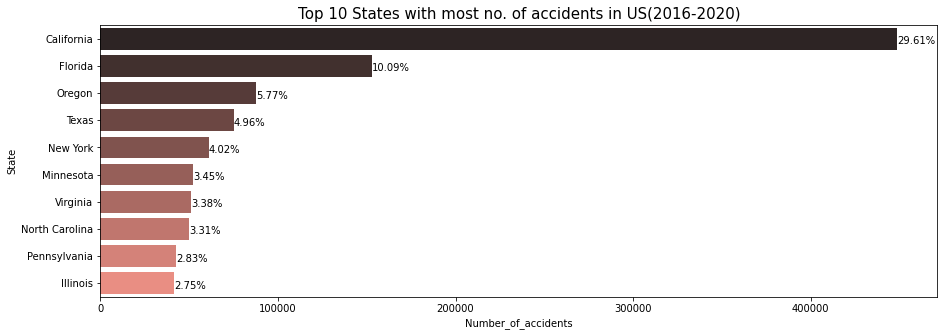

In [35]:
fig,ax = plt.subplots(figsize = (15,5))

#barchart
chart= sns.barplot(x="Number_of_accidents", y="State", data=df_state.head(10), palette="dark:salmon")

total_accident= sum(df_state.Number_of_accidents)

#show percentage
i=0
for c in chart.patches:
    width, height = c.get_width(), c.get_height()
    x, y = c.get_xy()
    plt.text(x+width,
             y+height*0.75,
             str(round(df_state.Number_of_accidents[i]/total_accident*100, 2))+"%")
    i+=1
    
plt.title("Top 10 States with most no. of accidents in US(2016-2020)", size=15)
plt.show()

In [36]:
t= sum(df_state.Number_of_accidents[:5])
print(f'Accidents in top 5 states combined: {round(t/total_accident*100)} %')

Accidents in top 5 states combined: 54 %


In [59]:
print(df_state[['State','Number_of_accidents']][:5])

        State  Number_of_accidents
0  California               448833
1     Florida               153007
2      Oregon                87484
3       Texas                75142
4    New York                60974


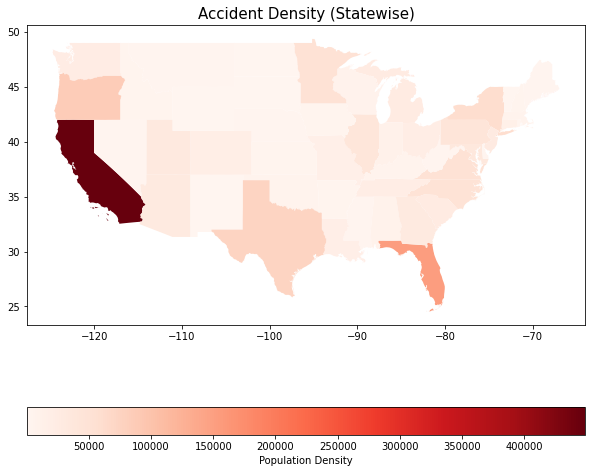

In [80]:
fig,ax = plt.subplots(figsize = (10,10))

#creating a column to join on
df_state['NAME']=df_state['State']

#adding number of accidents in 'states' gpd dataframe and plotting it
map= states.merge(df_state, on='NAME').plot(column='Number_of_accidents', 
                                       cmap='Reds', 
                                       legend=True,
                                       legend_kwds={'label': "Population Density",'orientation':"horizontal"},
                                       ax=ax)
plt.title("Accident Density (Statewise)", size=15)
plt.show()

><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
>- Approx. **30**% of the accidents took place in **California** alone. A total of **448,833** accidents happended in this state.
>- **153,007** accidents, i.e, **10**% happened in Florida.
>- **More than half** (54%) of all the accidents took place in just **5** states (California, Florida, Oregon, Texas, and NewYork)

### Time

#### Hour

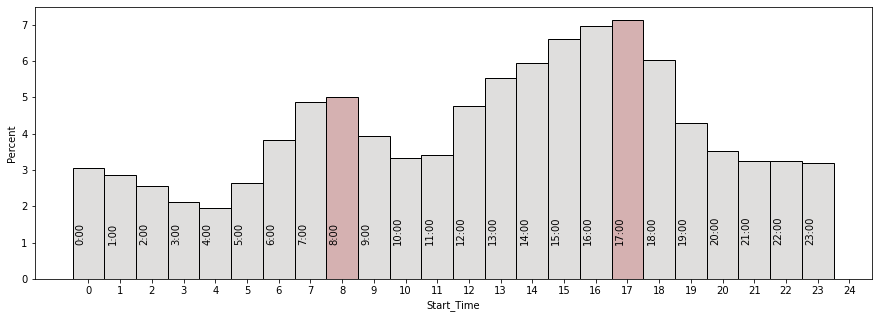

In [113]:
fig,ax = plt.subplots(figsize = (15,5))
ax.xaxis.set_ticks(list(range(0,25)))

#plot histogram 
chart= sns.histplot(df.Start_Time.dt.hour, stat='percent', bins=24, discrete=True, color='#d5d4d2')

#highlighting peaks
for i in [7,8,16,17]:
  chart.patches[i].set_facecolor('#d5b1b1')

#text annotation
i=0
for c in  chart.patches:
    width, height = c.get_width(), c.get_height()
    x, y = c.get_xy()
    plt.text(x+0.1,
             y+1,
             str(i)+":00",
             size=10,
             rotation='vertical')
    i+=1
plt.show()

><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
>- Number of accidents increases around **8 AM** and **5 PM**.
>- People usually **go to work** and **return home** around 8 AM and 5 PM respectively; thus **increasing** traffic volume.
>- More accidents at 5 PM compared to 8AM can be because of two factors. Firstly, people are **more tired** while returning home. Secondly, **visibility is less** at dusk.

#### Week

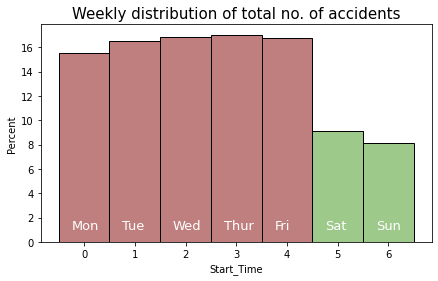

In [163]:
fig,ax = plt.subplots(figsize = (7,4))

#plot histogram 
chart= sns.histplot(df.Start_Time.dt.dayofweek, stat='percent', bins=7, discrete=True, color='grey')

days_of_week= ("Mon","Tue","Wed","Thur","Fri","Sat","Sun")

#separate colour for weekdays and weekend
for i in range(5):
  chart.patches[i].set_facecolor("#bf7f7f")
chart.patches[5].set_facecolor("#9dc98a")
chart.patches[6].set_facecolor("#9dc98a")

#annotation
i=0
for c in  chart.patches:
    width, height = c.get_width(), c.get_height()
    x, y = c.get_xy()
    plt.text(x+0.25,
             y+1,
             days_of_week[i],
             size=13,
             c='white')
    i+=1

plt.title("Weekly distribution of total no. of accidents", size=15)
plt.show()

In [138]:
print(round(sum(df.Start_Time.dt.dayofweek.value_counts()[:5])/len(df)*100),"%")

83 %


><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
>- **83**% of the accidents took place on **weekdays**
>- **17**% on **weekends**
>- Less accidents occurs on weekends as comparitively lesser number of people go out comparitively.

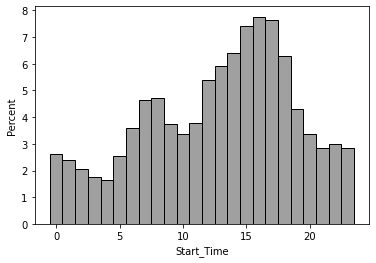

In [143]:
chart= sns.histplot(df.Start_Time.dt.hour[df.Start_Time.dt.dayofweek==4], 
                    stat='percent', bins=12, discrete=True, color='grey')

#### Month

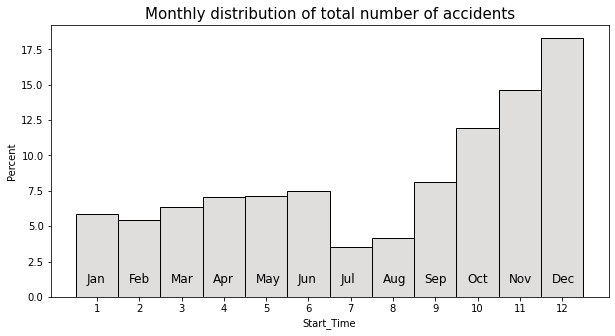

In [154]:
fig,ax = plt.subplots(figsize = (10,5))
ax.xaxis.set_ticks(list(range(1,13)))

month_of_year= ('#','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

#plot histogram
chart= sns.histplot(df.Start_Time.dt.month, stat='percent', bins=12, discrete=True, color='#d5d4d2')

#annotate
i=1
for c in  chart.patches:
    width, height = c.get_width(), c.get_height()
    x, y = c.get_xy()
    plt.text(x+0.25,
             y+1,
             str(month_of_year[i]),
             size=12)
    i+=1

plt.title("Monthly distribution of total number of accidents",size=15)
plt.show()

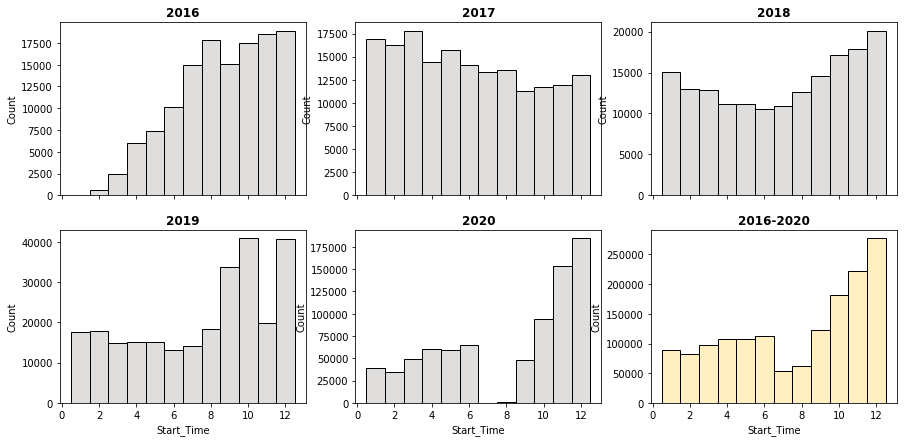

In [173]:
fig, axes = plt.subplots(2,3, figsize=(15, 7), sharex=True)
a=[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]

#plotting monthly distribution for year each
for i in range(5):
  sns.histplot(df.Start_Time.dt.month[df.Start_Time.dt.year==2016+i], 
               stat='count', bins=12, discrete=True, color='#d5d4d2', ax=axes[a[i]])
  axes[a[i]].set_title(str(2016+i), fontweight="bold")

#plotting total monthly distribution
sns.histplot(df.Start_Time.dt.month, stat='count', bins=12, discrete=True, color='#ffeaad', ax=axes[a[5]])
axes[1,2].set_title('2016-2020',fontweight="bold")

plt.show()

><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
> - October, Novemeber, December is showing unusually high number of accidents. Might be a data collection problem.
> - On 2016 number of accidents linearly increases. Probably, the survey started on Feb 2016 and the survey size kept increasing henceforth.
> - 2017 and 2018 depicts a well distributed number of accidents per month.
> - Unusually huge spike in accidents on Sept2019-Dec2019. Similar pattern is observed in 2020. Might be a overlap of multiple surveys or change in sample size.
> - Monthly survey count is not uniformly distribute, sudden spike in accident from August2019 to Sept2019 is incomprehensible.
> - 2020 survey might be affected by covid-19 pandemic.

#### Year

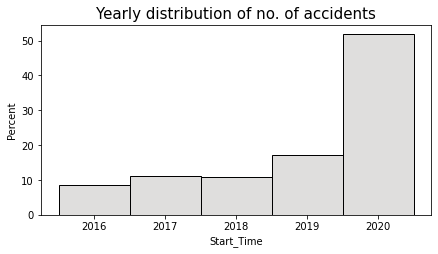

In [179]:
fig,ax = plt.subplots(figsize = (7,3.5))

#histogram
sns.histplot(df.Start_Time.dt.year, stat='percent', discrete=True ,bins=5, color='#d5d4d2')

plt.title("Yearly distribution of no. of accidents", size=15)
plt.show()

><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
>- Data shows yearly increase in recorded number of accidents.
>- Huge increase in survey size in 2020, almost triple.

#### Day/Night

In [45]:
df['Sunrise_Sunset'].value_counts()

Day      909838
Night    606143
Name: Sunrise_Sunset, dtype: int64

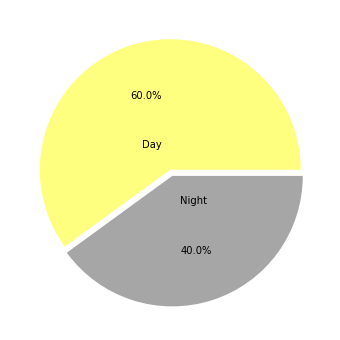

In [46]:
fig,ax = plt.subplots(figsize = (6,6))

#pie chart
plt.pie(df['Sunrise_Sunset'].value_counts(), 
        labels=['Day','Night'], 
        autopct='%1.1f%%',
        colors=['#ffff7f','#a6a6a6'],
        explode=[0,0.05],
        labeldistance=0.2)

plt.show()

><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
>- **60**% of the accidents take place at daytime.
>- It should be noted that US gets **15** hours of daylight on average, i.e 62.5% of a day. 

### Condition

#### Road/Vicinity

In [272]:
entity= ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
             'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

In [273]:
#dataframe containing number of accidents caused by each entity
df_entity= pd.DataFrame(columns=['Entity','Number_of_accidents'])

#iterating through all 13 columns
for e in entity:
  #counting trues,i.e, total-falses
  number_of_accidents= sum(df[e].value_counts()) - df[e].value_counts()[0]
  df_entity= df_entity.append({'Entity': e,'Number_of_accidents': number_of_accidents}, 
                                              ignore_index=True )

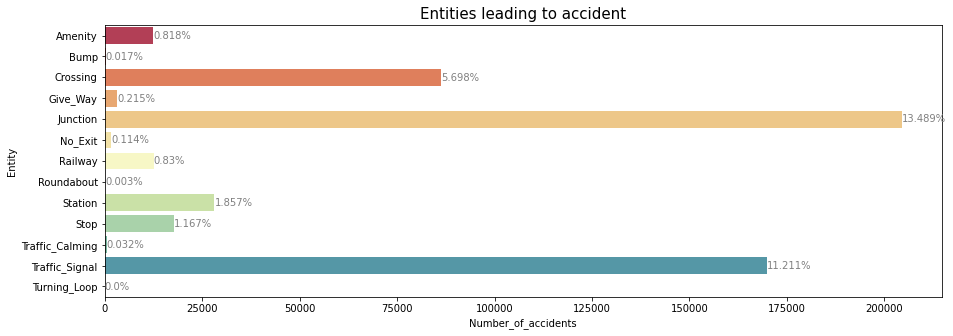

In [274]:
fig,ax = plt.subplots(figsize = (15,5))

#plotting barchart
chart= sns.barplot(y=df_entity['Entity'], 
                   x=df_entity['Number_of_accidents'],
                   palette='Spectral')

total_accidents=len(df)

#annotating barchart
i=0
for c in chart.patches:
    width, height = c.get_width(), c.get_height()
    x, y = c.get_xy()
    plt.text(x+width,
             y+height-0.25,
             str(round(df_entity['Number_of_accidents'][i]/total_accidents*100,3))+"%",
             size=10, c='grey')
    i+=1

plt.title("Entities leading to accident", size=15)
plt.show()

In [288]:
print(round(sum(df_entity['Number_of_accidents'])/len(df)*100),"%")

35 %


In [276]:
df_entity= df_entity.sort_values("Number_of_accidents", ascending=False, ignore_index=True)

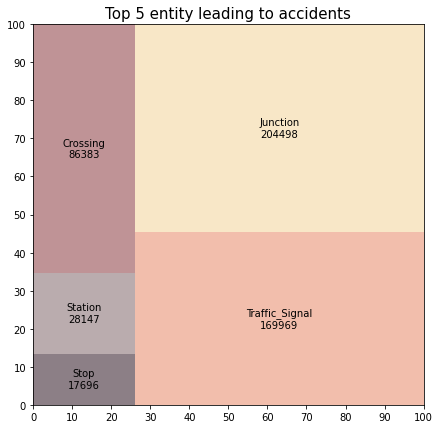

In [283]:
fig,ax = plt.subplots(figsize = (7,7))
ax.xaxis.set_ticks(list(range(0,101,10)))
ax.yaxis.set_ticks(list(range(0,101,10)))

#plotting treemap
squarify.plot(sizes= list(df_entity['Number_of_accidents'][:5])[::-1],
            label=(df_entity.Entity+"\n"+df_entity.Number_of_accidents.apply(lambda x: str(x)))[:5][::-1],
            color=['#66545e','#a39193','#aa6f73','#eea990','#f6e0b5'], alpha=0.75)

plt.title("Top 5 entity leading to accidents",size=15)
plt.show()

><img src="https://cdn-icons-png.flaticon.com/512/702/702797.png" weight=50px height= 50px> *INSIGHTS*:
>- **13.5**% of the accidents took place at a **juction**; followed by **11.2**% at **traffic signals**.
>- **65**% of the accidents **doesn't** take place around any of these entities.

#### Weather

In [51]:
df_weather= df['Weather_Condition'].value_counts().reset_index().rename(columns={'index':'Weather_Condition',
                                                                     'Weather_Condition':'Number_of_accidents'})

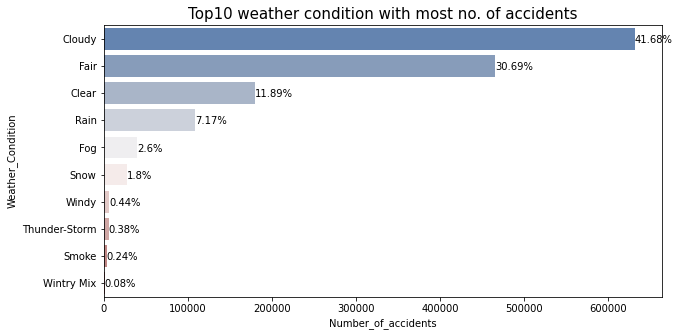

In [280]:
fig,ax = plt.subplots(figsize = (10,5))

#plotting barchart
chart= sns.barplot(y=df_weather['Weather_Condition'][:10], 
            x=df_weather['Number_of_accidents'][:10],
            palette="vlag")

total_accidents=len(df)

#annotating barchart
i=0
for c in chart.patches:
    width, height = c.get_width(), c.get_height()
    x, y = c.get_xy()
    plt.text(x+width,
             y+height-0.25,
             str(round(df_weather['Number_of_accidents'][i]/total_accidents*100,2))+"%",
             size=10)
    i+=1

plt.title("Top10 weather condition with most no. of accidents", size=15)
plt.show()

### Impact on traffic

#### Severity

In [54]:
df_severity= pd.DataFrame(df['Severity'].value_counts())

df_severity= df_severity.reset_index().rename(columns={'index':'Severity', 'Severity': 'Number_of_accidents'})


In [55]:
df_severity

,Severity,Number_of_accidents
0,2,1212382
1,3,161052
2,4,114452
3,1,28178


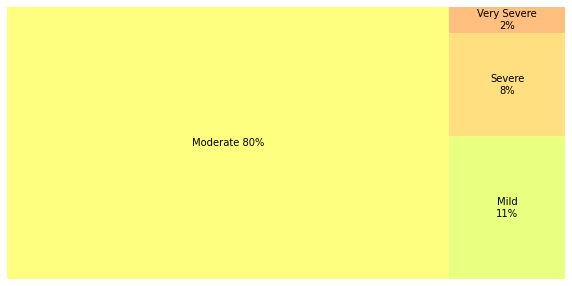

In [56]:
fig,ax = plt.subplots(figsize = (10,5))

perc= [round(x/sum(df_severity['Number_of_accidents'])*100) for x in df_severity['Number_of_accidents']] 


squarify.plot(sizes=perc,
              label=[f'Moderate {perc[0]}%',f'Mild\n{perc[1]}%',f'Severe\n{perc[2]}%',f'Very Severe\n{perc[3]}%'],
              color=['#ffff00', '#d5ff00', '#ffc000', '#ff8000'],
              alpha=0.5)
plt.axis('off')
plt.show()

#### Duration

In [57]:
df_duration= pd.DataFrame()
df_duration['Time_Diff']= (df['End_Time']-df['Start_Time']).dt.seconds//(60*60)
df_duration= pd.DataFrame(df_duration.value_counts())
df_duration= df_duration.reset_index().rename(columns={'Time_Diff':'Hours',0:'Number_of_accidents'})
df_duration['Hours']= df_duration['Hours'].apply(lambda x: str(x))

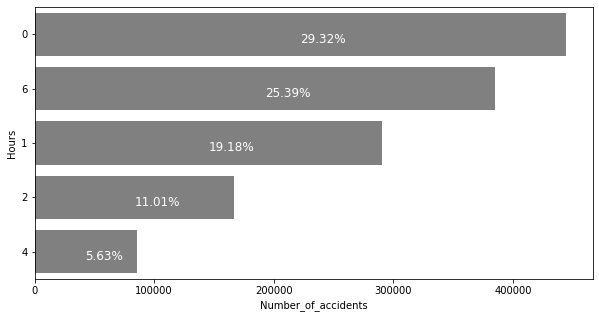

In [58]:
fig,ax = plt.subplots(figsize = (10,5))
chart= sns.barplot(y='Hours',
            x='Number_of_accidents',
            data=df_duration[:5],
            color='grey')

total_accidents=len(df)
i=0
for c in chart.patches:
    width = c.get_width()
    height = c.get_height()
    x, y = c.get_xy()
    plt.text(x+width/2,
             y+height-0.25,
             str(round(df_duration['Number_of_accidents'][i]/total_accidents*100,2))+"%",
             size=12, c='white')
    i+=1

## Insights